In [1]:
import itertools
import sympy as sp
from sympy import S
from moments import *
from maxwellian_equilibrium import *
from derivative import *

sp.init_printing()

# Creating all necessary symbols and functions
ε, ω, f, feq, F_q, dt, Λ, ρ = sp.symbols("ε ω f f^{(eq)} F_q Δt Λ rho")
a = sp.Matrix(sp.symbols("a_{:3}"))
c = sp.Matrix(sp.symbols("c_{:3}"))
u = sp.symbols("u_:3")
fi = sp.symbols("f^{((:4))}")
δ = lambda i,j: 1 if i==j else 0  # Kronecker δ

# Steady state Chapman Enskog Analysis of D3Q19 equilibria

In this notebook we describe in detail how to do a steady state Chapman Enskog analysis of the lattice Boltzmann equation up to third order. The equations get very lengthy with higher expansion orders and doing these calculations manually is highly error-prone. 
So we automatize every necessary algebraic step in the computer algebra system *sympy*. 

We extended *sympy* with special objects that represent differentials and differential operators, since the built-in derivative module was hard to adapt to our needs. These extensions together with documentation can be found in the `derivative.py` file. 

We start with the scaled LB equation with force term $F_q$, as described in detail in the paper

$$  f_q(\mathbf{x} + \epsilon \, \mathbf{c}_q, t) = f_q(\mathbf{x}, t) - \omega (f_q - f^{(eq)}) + \epsilon \left( 1 - \frac{\omega}{2} \right) F_q .$$


### Step 1: Taylor Expansion of left hand side

The left hand side is expanded in a Taylor series in $\epsilon$

$$   f_q(\mathbf{x} + \epsilon \, \mathbf{c}_q) = \sum_{n=0}^\infty  \frac{1}{n!} \left( \epsilon \; c_{qi} \partial_i \right)^n f_q(\mathbf{x}) $$

which we represent in *sympy* as a operator equation, using our customly written `DiffOperator` object.
The differential operator behaves like a non-commutative *sympy* symbol, and with the gradient operator `Dx`

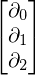

In [2]:
Dx = sp.Matrix([DiffOperator(target=l) for l in range(3)])
Dx

we can write the Taylor operator up to order 3 as

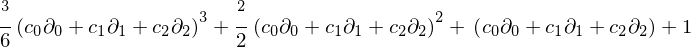

In [3]:
taylorExpansionOrder = 3
taylorOperator = sum((ε * c.dot(Dx)) ** n / sp.factorial(n) 
                     for n in range(taylorExpansionOrder + 1))
taylorOperator

Since the operator behaves like a normal symbol, we can expand this equation and apply the operator to the function $f$, yielding the fully Taylor expanded left hand side of the LB equation

In [4]:
taylorExpansionOfLhs = DiffOperator.apply(taylorOperator, f)

Equations are represented in *sympy* as terms, assuming an implicit "$=0$". 

The full LB equation with expanded left hand side reads

In [5]:
rhs = f - ω * (f - feq) + ε * (1 - ω/2) * F_q
latticeBoltzmannEq = taylorExpansionOfLhs - rhs
latticeBoltzmannEq

                         3  3                   2        3                   2
        ⎛  ω    ⎞   c_{0} ⋅ε ⋅D(D(D(f)))   c_{0} ⋅c_{1}⋅ε ⋅D(D(D(f)))   c_{0} 
- F_q⋅ε⋅⎜- ─ + 1⎟ + ──────────────────── + ────────────────────────── + ──────
        ⎝  2    ⎠            6                         2                      

        3                   2  2                      2  3                    
⋅c_{2}⋅ε ⋅D(D(D(f)))   c_{0} ⋅ε ⋅D(D(f))   c_{0}⋅c_{1} ⋅ε ⋅D(D(D(f)))         
──────────────────── + ───────────────── + ────────────────────────── + c_{0}⋅
      2                        2                       2                      

                                                                2  3          
             3                           2           c_{0}⋅c_{2} ⋅ε ⋅D(D(D(f))
c_{1}⋅c_{2}⋅ε ⋅D(D(D(f))) + c_{0}⋅c_{1}⋅ε ⋅D(D(f)) + ─────────────────────────
                                                                 2            

                                                 

### Step 2: Chapman Enskog ansatz

#### Step 2.1: Expanding $f$

The particle distribution function is then formally expanded in ε. In *sympy* this is a simple substitution of $f \rightarrow f^{(0)} + \epsilon f^{(1)} +  \epsilon^2 f^{(2)} + \epsilon^3 f^{(3)}$

In [6]:
expandedF = sum(ε**i * f for i, f in enumerate(fi))
expandedF

Inserting this into the LB equation gives us already a really lenghty and somewhat unreadable equation, since we cannot use Einstein summation convention in sympy - all terms are written out.

In [7]:
expandedLbEquation = latticeBoltzmannEq.subs(f, expandedF)  # insert expanded f into Taylor expanded LB equation
expandedLbEquation = expandUsingLinearity(expandedLbEquation, constants=[ε])  # split up derivatives and pull out ε
expandedLbEquation = expandedLbEquation.collect(ε)  # factor out ε
expandedLbEquation

                              ⎛     3                         2               
                            6 ⎜c_{0} ⋅D(D(D(f^{(3)})))   c_{0} ⋅c_{1}⋅D(D(D(f^
f__{(0)}⋅ω - f__{(eq)}⋅ω + ε ⋅⎜─────────────────────── + ─────────────────────
                              ⎝           6                            2      

                2                                     2                       
{(3)})))   c_{0} ⋅c_{2}⋅D(D(D(f^{(3)})))   c_{0}⋅c_{1} ⋅D(D(D(f^{(3)})))      
──────── + ───────────────────────────── + ───────────────────────────── + c_{
                         2                               2                    

                                             2                         3      
                                  c_{0}⋅c_{2} ⋅D(D(D(f^{(3)})))   c_{1} ⋅D(D(D
0}⋅c_{1}⋅c_{2}⋅D(D(D(f^{(3)}))) + ───────────────────────────── + ────────────
                                                2                            6

                   2                             

#### Step 2.2: Collecting by $\epsilon$ order

We are interested in the factors up to $\epsilon^3$, so we extract them from the equation above and 
put them into a dictionary. This dictionary maps an $\epsilon$ exponent to the corresponding equation.

In [8]:
eq = expandedLbEquation
εCoefficientDict = {order: eq.coeff(ε**order) if order > 0 else eq.subs(ε,0) 
                    for order in range(4)}

Lets, for example, check the term multiplying $\epsilon^1$:

In [9]:
εCoefficientDict[1]

F_q⋅ω                                                                         
───── - F_q + c_{0}⋅D(f^{(0)}) + c_{1}⋅D(f^{(0)}) + c_{2}⋅D(f^{(0)}) + f__{(1)
  2                                                                           

   
}⋅ω
   

We require the equation to be true for each $\epsilon$ order independently - thus these terms/equations can be used to determine the $f^{(i)}$.

For example from the lowest order equation we can extract $f^{(0)} = f^{(eq)}$

In [10]:
εCoefficientDict[0]

We can explicitly solve for $f^{(0)}$ using *sympy*s `solve` function:

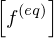

In [11]:
sp.solve(εCoefficientDict[0], fi[0])

This is now done hierarchically - $f^{(0)}$ is determined and inserted into the next higher equation, which is then solved for $f^{(1)}$. Then $f^{(0)}$ and $f^{(1)}$ are inserted into the next higher equation, that is solved for $f^{(3)}$.

In [12]:
fHierarchy = {f: sp.solve(εCoefficientDict[i], f)[0] for i, f in enumerate(fi)}
fHierarchyInserted = {fi[0]: fHierarchy[fi[0]] }
for f in fi[1:]:
    eq = fHierarchy[f].subs(fHierarchyInserted)
    eq = expandUsingLinearity(eq, functions= fi + (F_q,feq))
    fHierarchyInserted[f] = eq 
fHierarchyInserted    

⎧                                                                             
⎪                                 F_q   F_q   c_{0}⋅D(f^{(eq)})   c_{1}⋅D(f^{(
⎨f__{(0)}: f__{(eq)}, f__{(1)}: - ─── + ─── - ───────────────── - ────────────
⎪                                  2     ω            ω                   ω   
⎩                                                                             

                                            2                       2         
eq)})   c_{2}⋅D(f^{(eq)})              c_{0} ⋅D(D(f^{(eq)}))   c_{0} ⋅D(D(f^{(
───── - ─────────────────, f__{(2)}: - ───────────────────── + ───────────────
                ω                               2⋅ω                       2   
                                                                         ω    

                                                                              
eq)}))   c_{0}⋅c_{1}⋅D(D(f^{(eq)}))   c_{0}⋅c_{1}⋅D(D(f^{(eq)}))   c_{0}⋅c_{1}
────── - ────────────────────────── + ────────────

Above equations correspond to equation (23) in the paper - however without Einstein summation convention and without the replacement for $\Lambda$.

#### Step 2.3: Regrouping and moment computation

In this step we regroup the separate equations for different orders in $\epsilon$ to obtain the conservation equations for mass and momentum. We first do this in a generic way that is independent of the specific lattice model.

##### Step 2.3.1 General continuity equation
For the mass convervation (continuity) equation we start with  $\rho = \sum_q f = \sum_q f^{(eq)}$. This is true by construction of the equilibrium distribution function. Because $f^{(0)} = f^{(eq)}$ this is equivalent to 
$$ \sum_q \left( f_q - f_q^{(eq)} \right) = 0 $$
Inserting the $ε$ expanded approximation for $f$ gives
$$  \sum_q \left( \epsilon f_q^{(1)} + \epsilon^2 f_q^{(2)} + \epsilon^3 f_q^{(3)} \right)  = 0 $$

All $f^{(i)}$ terms have a similar structure. They can be divided into a sum of terms that are built of a monomial in $c$, multiplied by a derivative of the equilibrium distribution $f^{(eq)}$ or the force term $F_q$ and some constant prefactor involving $\omega$ and $\epsilon$. Lets pick an arbitrary term as an example:

$$ \frac{\epsilon}{\omega^3} c_{q1} c_{q2}^2 \partial_2 \partial_2 \partial_1 f^{(eq)} =  
 \underbrace{\frac{\epsilon}{\omega^3}}_{\mbox{const. prefactor}} \; \;
   \underbrace{c_{q1} c_{q2}^2}_{\mbox{polynomial in c}} \;\;\
   \underbrace{\partial_2 \partial_2 \partial_1 f^{(eq)}}_{\mbox{derivative of equilibrium}}  $$


Note that in the *sympy* output we write $c_i$ instead of $c_{qi}$ to not make the index cluttering worse.
The recombination $\epsilon f_q^{(1)} + \epsilon^2 f_q^{(2)} + \epsilon^3 f_q^{(3)}$ is a sum of such terms and we want to compute "$\sum_q$" of it. This sum is splitted up into single terms of the form described above. Lets see how this looks like for the example term

$$ \sum_q \frac{\epsilon}{\omega^3} c_{q1} c_{q2}^2 \partial_2 \partial_2 \partial_1 f^{(eq)} =
   \frac{\epsilon}{\omega^3}  \partial_2 \partial_2 \partial_1 \left(  \sum_q c_{q1} c_{q2}^2 f^{(eq)} \right) =
   \frac{\epsilon}{\omega^3}  \partial_2 \partial_2 \partial_1  \Pi^{(eq)}_{122}
$$  

We pull the constant $c$-terms and the q-sum into the derivative and write this construct as an equilibrium moment.
This transformation is handled by the following Python function `takeMoments`. It splits a product into prefactor, $c$ product and equilibrium derivative and inserts a special symbol `CeMoment`  i.e. $\Pi^{(eq)}$. The `CeMoment` behaves like a normal *sympy* symbol but additionally has index information attached to it in its `momentTuple` attribute. This `momentTuple` stores the exponents of the velocities e.g. $c_{q0}^3 c_{q1}^2$ is stored as $(3,2,0)$.

Not all terms have the form described above, since we included a force term in the LB equation. If the `takeMoments` method encounters $F_q$ instead of $f^{(eq)}$ as argument of the derivative, it replaces it with a `CeMoment` called $\Pi^{(F)}$.

In this work we assume that a first order force model is used (e.g. Buick et al.). This means that all moments are zero, except the first order moment $\sum_q c_{qi} F_q = a_i$, which is equal to the acceleration. 
The function `insertForceMoments` replaces the $\Pi^{(F)}$'s with their value.

In [13]:
feqMomentName = "\\Pi^{(eq)}"
forceMomentName = "\\Pi^{(F)}"

def takeMoments(expr):
    expr = expr.expand()
    result = 0

    for product in expr.args if expr.func is sp.Add else [expr]:
        otherFactors = []
        indices = [0, 0, 0]
        diff = None
        for factor in normalizeProduct(product):
            if factor in c:
                i = list(c).index(factor)
                indices[i] += 1
            elif isinstance(factor, Diff):
                assert diff is None, "More than one differential in term " + str(product)
                diff = factor
            else:
                otherFactors.append(factor)
        if diff is None:
            assert feq in otherFactors or F_q in otherFactors, str(otherFactors)
            arg = feq if feq in otherFactors else F_q
            otherFactors = [e for e in otherFactors if e not in (feq, F_q)]
            moment = CeMoment(feqMomentName if arg == feq else forceMomentName, tuple(indices))
            result += prod(otherFactors) * moment           
        else:
            arg = diff.getArgRecursive()
            assert arg in (feq, F_q)
            moment = CeMoment(feqMomentName if arg == feq else forceMomentName, tuple(indices))
            result += prod(otherFactors) * diff.changeArgRecursive(moment)
    return normalizeDiffOrder(result)

def insertForceMoments(eq):
    # replace first order force moments with acceleration
    eq = eq.subs({CeMoment(forceMomentName, (1,0,0)): a[0], 
                  CeMoment(forceMomentName, (0,1,0)): a[1], 
                  CeMoment(forceMomentName, (0,0,1)): a[2]})

    # all other force moments are zero
    eq = eq.subs({m: 0 for m in eq.atoms(CeMoment) if m.name == forceMomentName})
    return eq

With these function we have all building blocks in place to formulate the recombined continuity equation in its lattice model independent formulation, using equilibrium moments. To simplify the equations we substitute the relaxation parameter $\omega$ by $\frac{1}{\Lambda + \frac{1}{2}}$

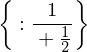

In [14]:
ΛSubs = { ω : 1 / (Λ + S(1)/2) }
ΛSubs

In [15]:
genericContinuityEq = takeMoments((expandedF - feq).subs(fHierarchyInserted) / ε * ω)
genericContinuityEq = insertForceMoments(genericContinuityEq).subs(ΛSubs).expand().collect(ε)
genericContinuityEq

 2 ⎛   2                                         2                            
ε ⋅⎜- Λ ⋅D(D(D(\Pi^{(eq)}_(-1)_(0, 0, 3)))) - 3⋅Λ ⋅D(D(D(\Pi^{(eq)}_(-1)_(0, 1
   ⎝                                                                          

             2                                       2                        
, 2)))) - 3⋅Λ ⋅D(D(D(\Pi^{(eq)}_(-1)_(0, 2, 1)))) - Λ ⋅D(D(D(\Pi^{(eq)}_(-1)_(
                                                                              

                 2                                         2                  
0, 3, 0)))) - 3⋅Λ ⋅D(D(D(\Pi^{(eq)}_(-1)_(1, 0, 2)))) - 6⋅Λ ⋅D(D(D(\Pi^{(eq)}_
                                                                              

                       2                                         2            
(-1)_(1, 1, 1)))) - 3⋅Λ ⋅D(D(D(\Pi^{(eq)}_(-1)_(1, 2, 0)))) - 3⋅Λ ⋅D(D(D(\Pi^{
                                                                              

                             2                  

This is equation (25) of the paper, but very hard to read since no Einstein summation convention can be used in *sympy*.
$$- \partial_i \Pi^{(eq)}_i + 
\epsilon \Lambda  \left( \partial_i \partial_j \Pi^{(eq)}_{ij} - \partial_i a_i \right)
- \epsilon^2 \left( \Lambda^2 - \frac{1}{12} \right) \partial_i \partial_j \partial_k \Pi^{(eq)}_{ijk} 
% + \epsilon^3 \left(  \Lambda^3 - \frac{\Lambda}{6} \right) \partial_i \partial_j \partial_k \partial_l \Pi^_{(eq)}_{ijkl} + \cdots 
= 0$$

To make sure both equations are indeed equal, we write down equation (25) in sympy and check for equality. Additionally the function `normalizeDiffOrder` is used to bring all derivatives into the same order, since e.g. $\partial_1 \partial_2$ is not considered equal to $\partial_2 \partial_1$ by *sympy*.

In [16]:
# Define summation over 1, 2 and 3 indices
s1 = [0,1,2]
s2 = list(itertools.product(s1,s1))
s3 = list(itertools.product(s1,s1,s1))

# shorthand function to create equilibrium moment symbols
Pi = lambda *i: CeMoment(feqMomentName, tuple(sum(1 if e==k else 0 for e in i) for k in range(3)))

# equation (25) from the paper
referenceContinuityEq = - ε**0 * sum(Diff(Pi(i),i) for i in s1) \
                        + ε**1 * Λ * ( sum( d(Pi(i,j), i,j) for i,j in s2) - sum(Diff(a[i],i) for i in s1)) \
                        - ε**2 * (Λ**2 - S(1)/12) * sum( d(Pi(i,j,k), i,j,k) for i,j,k in s3 )
normalizeDiffOrder(referenceContinuityEq).collect(ε)

assert sp.expand(referenceContinuityEq - genericContinuityEq) == 0, "Automatically derived version is not the same as version in paper"

##### Step 2.3.1 General momentum conservation equation

Similarly the momentum conservation equations can be obtained, by taking the first instead of the zeroth moment.
In addition the velocity shift due to the force model has to be considered as well.

$$ \sum_q c_{qh} \left( \epsilon f_q^{(1)} + \epsilon^2 f_q^{(2)} + \epsilon^3 f_q^{(3)} \right)  = - \frac{\epsilon}{2} \sum_q c_{qh} F_q  $$

Starting with this equation, applying the `takeMoments` and `insertForceMoments` from above, we obtain the generic momentum conservation equation for the x-momentum, since `h` is chosen as 0.

In [17]:
genericMomentumEq = -sp.Matrix([(expandedF - feq) * c[h] + ε/2 * c[h] * F_q for h in range(3)])
genericMomentumEq = genericMomentumEq.subs(fHierarchyInserted) / ε * ω
genericMomentumEq = genericMomentumEq.applyfunc(takeMoments).applyfunc(insertForceMoments).applyfunc(lambda t: t.collect(ε))
genericMomentumEq = genericMomentumEq.subs(ΛSubs).applyfunc(normalizeDiffOrder)
genericMomentumEq[0]

                                                                              
          2  2                                         2  2                   
-a_{0} + Λ ⋅ε ⋅D(D(D(\Pi^{(eq)}_(-1)_(1, 0, 3)))) + 3⋅Λ ⋅ε ⋅D(D(D(\Pi^{(eq)}_(
                                                                              

                                                                              
                      2  2                                       2  2         
-1)_(1, 1, 2)))) + 3⋅Λ ⋅ε ⋅D(D(D(\Pi^{(eq)}_(-1)_(1, 2, 1)))) + Λ ⋅ε ⋅D(D(D(\P
                                                                              

                                                                              
                                2  2                                         2
i^{(eq)}_(-1)_(1, 3, 0)))) + 3⋅Λ ⋅ε ⋅D(D(D(\Pi^{(eq)}_(-1)_(2, 0, 2)))) + 6⋅Λ 
                                                                              

                                                 

In the next cell we check that this is indeed equation (28) of the paper

In [18]:
for h in range(3):
    referenceMomentumEq =  sum(Diff(Pi(i, h), i) for i in s1) \
                          - ε * Λ * sum( d(Pi(i,j,h), i, j) for i,j in s2) \
                          + ε**2 * (Λ**2 - S(1)/12) * sum(d(Pi(i,j,k,h), i,j,k) for i,j,k in s3) \
                          - a[h]
    assert sp.expand(referenceMomentumEq - genericMomentumEq[h]) == 0,  "Automatically derived version is not the same as version in paper"

### Step 3: Lattice Model specific equations

The lattice model specific equations can be obtained by inserting values for the equilibrium moment symbols. 
In the supplementary material notebook for section 3 we have already demonstrated how equilibrium moment can be computed in *sympy*. Therefor, the stencil directions have to be defined,

In [19]:
D3Q19 = ((0, 0, 0),
        (0, 1, 0), (0, -1, 0), (-1, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0, -1),
        (-1, 1, 0), (1, 1, 0), (-1, -1, 0), (1, -1, 0),
        (0, 1, 1), (0, -1, 1), (-1, 0, 1), (1, 0, 1),
        (0, 1, -1), (0, -1, -1), (-1, 0, -1), (1, 0, -1))
D3Q27 = ((0, 0, 0),
         (0, 1, 0), (0, -1, 0), (-1, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0, -1),
         (-1, 1, 0), (1, 1, 0), (-1, -1, 0), (1, -1, 0),
         (0, 1, 1), (0, -1, 1), (-1, 0, 1), (1, 0, 1),
         (0, 1, -1), (0, -1, -1), (-1, 0, -1), (1, 0, -1),
         (1, 1, 1), (-1, 1, 1), (1, -1, 1), (-1, -1, 1), (1, 1, -1), (-1, 1, -1), (1, -1, -1), (-1, -1, -1))

The D3Q27 and D3Q19-S model are obtained by taking the Hermite-discretized well-known LB equilibrium and compute the moments from the discrete forms.

In [20]:
eqD3Q27  = discreteMaxwellianEquilibrium(D3Q27, order=2, compressible=False)
eqD3Q19S = discreteMaxwellianEquilibrium(D3Q19, order=2, compressible=False)

D3Q19S_moment = lambda expTuple: discreteMoment(eqD3Q19S, expTuple, D3Q19).expand()
D3Q27_moment  = lambda expTuple: discreteMoment(eqD3Q27,  expTuple, D3Q27).expand()

The improved D3Q19-I equilibrium is constructed as described in the previous notebook 

In [21]:
d3q27moments = momentsUpToComponentOrder(2, dim=3)
exponentsToLeaveOut = extendMomentsWithPermutations([(1, 2, 2), (1, 1, 2), (2, 2, 2), (1, 1, 1)])
d3q19moments = tuple(m for m in d3q27moments if m not in exponentsToLeaveOut)

d3q19meq = getMomentsOfContinuousMaxwellianEquilibrium(d3q19moments, dim=3, order=2, c_s_sq=S(1)/3)
d3q19meq = tuple(compressibleToIncompressibleMomentValue(v) for v in d3q19meq)

eqD3Q19I = momentMatrix(moments=d3q19moments, stencil=D3Q19).inv() * sp.Matrix(d3q19meq)
D3Q19I_moment = lambda expTuple: discreteMoment(eqD3Q19I, expTuple, D3Q19).expand()

The function `insertMoments` receives an expression with symbolic moments $\Pi^{(eq)}$ and inserts their value, that is obtained by calling the passed `momentGetter` function.

In [22]:
def insertMoments(expr, momentGetter):
    moments = expr.atoms(CeMoment)
    result = expr.subs({m: momentGetter(m.momentTuple) for m in moments})
    return result.applyfunc(expandUsingLinearity) if isinstance(result, sp.Matrix) else expandUsingLinearity(result)

#### Step  3.1: Continuity equation


The continuity equation for the D3Q27 model reads

In [23]:
d3q27_continuity_eq = insertMoments(genericContinuityEq, D3Q27_moment)
d3q27_continuity_eq

                                                                              
   2  2                 2  2                 2  2                 2  2        
- Λ ⋅ε ⋅D(D(D(u_0))) - Λ ⋅ε ⋅D(D(D(u_0))) - Λ ⋅ε ⋅D(D(D(u_0))) - Λ ⋅ε ⋅D(D(D(u
                                                                              

                                                                              
         2  2                 2  2                 2  2                 2  2  
_1))) - Λ ⋅ε ⋅D(D(D(u_1))) - Λ ⋅ε ⋅D(D(D(u_1))) - Λ ⋅ε ⋅D(D(D(u_2))) - Λ ⋅ε ⋅D
                                                                              

                                                                              
               2  2                                                           
(D(D(u_2))) - Λ ⋅ε ⋅D(D(D(u_2))) - Λ⋅ε⋅D(a_{0}) - Λ⋅ε⋅D(a_{1}) - Λ⋅ε⋅D(a_{2}) 
                                                                              

                                                 

We get the incompressible continuity equation $\partial_i u_i = 0$ with error terms that vanish if $\epsilon \rightarrow 0$.


The continuity equation is the same up to second order in $\epsilon$ for all three models. This is checked in the next cell

In [24]:
assert d3q27_continuity_eq - insertMoments(genericContinuityEq, D3Q19I_moment) == 0
assert d3q27_continuity_eq - insertMoments(genericContinuityEq, D3Q19S_moment) == 0

The interesting part is to compare the higher order error terms of the momentum conservation equations. These are different for the three investigated lattice models.

#### Step 3.3: Momentum conservation equation

Next, we insert the equilibrium moments of the three different lattice models into the generic momentum conservation equation.

In [25]:
d3q27_momentum_eq =  insertMoments(genericMomentumEq, D3Q27_moment)
d3q19i_momentum_eq = insertMoments(genericMomentumEq, D3Q19I_moment)
d3q19s_momentum_eq = insertMoments(genericMomentumEq, D3Q19S_moment)

Up to order $\epsilon$ they should all give the same result, namely the left hand side of equation (30).
This is checked in the next cell. 

To check for equivalence we write down the equation with Einstein summation convention named `eq_30_ref` and compare its value to the automatically derived terms.

In [26]:
def equalUpToEpsilonOrder3(e1, e2):
    diff = e1 - e2 + sp.Order(ε**2)
    diff = expandUsingLinearity(diff.removeO())
    return diff.expand() == 0

# Eq (30) without error terms
for h in range(3):
    eq_30_ref = sum(Diff(ρ/3 * δ(i, h) + u[i] * u[h], i) for i in s1) - a[h] \
                    - ε * Λ / 3 * sum( d(u[h], i, i) + 2 * d(u[i], i, h) for i in s1)
    
    assert equalUpToEpsilonOrder3(eq_30_ref, d3q27_momentum_eq[h])
    assert equalUpToEpsilonOrder3(eq_30_ref, d3q19i_momentum_eq[h])
    assert equalUpToEpsilonOrder3(eq_30_ref, d3q19s_momentum_eq[h])

The terms multiplied by $\epsilon^2$ in the momentum conservation equations actually differ between the three lattice models. In the next cell we implement a function that extracts this second order contribution $E_2$.

To better see the differences between the models we assume that $\rho$ is constant in the complete domain.

In [27]:
def get_e2_term(expr):
    prefactor = -(Λ**2 - S(1)/12)
    expr = expr.applyfunc(lambda e: e.collect(ε))
    expr = expr.applyfunc(lambda e: e.coeff(ε**2))
    expr = expr.applyfunc(lambda e: expandUsingLinearity(e, constants=[ρ]))
    return -(expr / prefactor).applyfunc(sp.cancel)

Again, we explicitly check that the automatically derived version is equal to the version in the paper for equations (31)-(33).

In [28]:
# Equation (31)
e2_d3q27_ref = sp.Matrix([  sum(d(u[h] * u[j], i, i, j) for i,j in s2)\
                          + sum(d(u[i] * u[j], i, j, h) for i,j in s2)\
                          - d(u[h] ** 2, h, h, h) \
                          for h in range(3)])
assert e2_d3q27_ref  == get_e2_term(d3q27_momentum_eq)


# Equation (32)
e2_d3q19i_ref =  sp.Matrix([      sum(d(u[h] * u[h], h, i, i) for i in s1)\
                            + 3 * sum(d(u[h] * u[i], h, h, i) for i in s1)\
                            +     sum(δ(i, j) * d(u[j] * u[h], i, i, j) for i, j in s2)\
                            +     sum(δ(i, j) * d(u[j] * u[j], h, i, i) for i, j in s2)\
                            - 5 * d(u[h] * u[h], h, h, h)\
                            for h in range(3)])
assert e2_d3q19i_ref == get_e2_term(d3q19i_momentum_eq)


# Equation (33)
e2_d3q19s_ref =  e2_d3q19i_ref - \
                sp.Matrix([sum( (1 - δ(i,j)) * (1 - δ(i,h)) * (1 - δ(j, h)) * d(u[j]**2, i, i, h) for i,j in s2) / 2
                           for h in range(3)])
assert e2_d3q19s_ref == get_e2_term(d3q19s_momentum_eq)

To better see why the three lattice models behave differently in the flows investigated, we restrict ourselves to the case where there is no velocity change in $x$ direction, i.e. $\partial_0 (\cdot) = 0$. 
This is true for the channel flows investigated in the paper. 

The next three cells correspond to equations (34)-(36) in the paper.

In [29]:
e2_d3q27 = get_e2_term(d3q27_momentum_eq)
e2_d3q27.applyfunc(lambda e: zeroDiffs(e, 0)) 

⎡         D(D(D(u_0*u_1))) + D(D(D(u_0*u_1))) + D(D(D(u_0*u_2))) + D(D(D(u_0*u
⎢                                                                             
⎢D(D(D(u_1**2))) + D(D(D(u_1**2))) + D(D(D(u_2**2))) + 3⋅D(D(D(u_1*u_2))) + D(
⎢                                                                             
⎣D(D(D(u_1**2))) + D(D(D(u_2**2))) + D(D(D(u_2**2))) + D(D(D(u_1*u_2))) + 3⋅D(

_2)))         ⎤
              ⎥
D(D(u_1*u_2)))⎥
              ⎥
D(D(u_1*u_2)))⎦

In [30]:
e2_d3q19i = get_e2_term(d3q19i_momentum_eq)
e2_d3q19i.applyfunc(lambda e: zeroDiffs(e, 0)) 

⎡                            D(D(D(u_0*u_1))) + D(D(D(u_0*u_2)))              
⎢                                                                             
⎢D(D(D(u_1**2))) + D(D(D(u_1**2))) + D(D(D(u_2**2))) + 3⋅D(D(D(u_1*u_2))) + D(
⎢                                                                             
⎣D(D(D(u_1**2))) + D(D(D(u_2**2))) + D(D(D(u_2**2))) + D(D(D(u_1*u_2))) + 3⋅D(

              ⎤
              ⎥
D(D(u_1*u_2)))⎥
              ⎥
D(D(u_1*u_2)))⎦

In [31]:
e2_d3q19s = get_e2_term(d3q19s_momentum_eq)
e2_d3q19s.applyfunc(lambda e: zeroDiffs(e, 0))

⎡                                      D(D(D(u_0*u_1))) + D(D(D(u_0*u_2)))    
⎢                                                                             
⎢  D(D(D(u_0**2)))                                                            
⎢- ─────────────── + D(D(D(u_1**2))) + D(D(D(u_1**2))) + D(D(D(u_2**2))) + 3⋅D
⎢         2                                                                   
⎢                                                                             
⎢  D(D(D(u_0**2)))                                                            
⎢- ─────────────── + D(D(D(u_1**2))) + D(D(D(u_2**2))) + D(D(D(u_2**2))) + D(D
⎣         2                                                                   

                                  ⎤
                                  ⎥
                                  ⎥
(D(D(u_1*u_2))) + D(D(D(u_1*u_2)))⎥
                                  ⎥
                                  ⎥
                                  ⎥
(D(u_1*u_2))) + 3⋅D(D(D(u_1*u_2)))⎥


Only the D3Q19S model has a $u_0$ error contribution in the y and z coordinate of the momentum conservation equation. Because of these error terms we can observe spurious currents normal to the flow direction (in y-z plane) of the channel. 